# *Image processing of corroded pit - part 1: masks generation*
Image processing of CERIC microCT beamtime *20217193_Traviglia* - ELETTRA SYRMEP
- By [Gianluca Iori](https://github.com/gianthk), Giulia Franceschin, Roberta Zanin, Elena Longo, 2023
- Code licence: MIT
- Narrative licence: CC-BY 
- Created on:  22.04.2022
- Last update: 28.02.2023

---
# Aims

1. Generate binary mask of the whole corrosion pit
2. Generate binary mask of the pit bottom
3. Generate binary mask of crystal inclusions

In [1]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Beamtime|20217193_Traviglia - CERIC|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

---
# *Computational workflow*

## Configuration and imports

In [2]:
import sys
sys.path.append('./../../recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

Configure working folder (change this to your local path)

In [3]:
work_folder = "/run/media/beats/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt"
# work_folder = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
# work_folder = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'

In [5]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, misc
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
from imaging_utils import remove_unconnected, remove_largest

Matplotlib plotting configuration

In [6]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

## Load 3D data
For practical reasons we can also load a small portion of the reconstructed dataset: slices [3890, 4645]

In [6]:
input_file = work_folder+'/slices_crop/slice_0000.tif' # 32bit data

In [7]:
# input_file = work_folder+'/slices_8bit_crop/slice_0000.tif' # 8bit data

Read portion of the file

In [2]:
# data_3D = read_tiff_stack(input_file, [3890, 4645])

Read whole file

In [7]:
data_3D = read_tiff_stack(input_file)

Voxelsize:

In [8]:
vs = np.ones(3)*1.0e-3 # [mm]

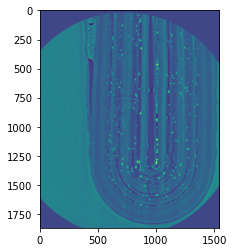

In [10]:
# Inspect slice
plt.imshow(data_3D[-1,:,:])

## Pre-processing
### Gaussian smooth (don't)

In [131]:
# data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (don't)

In [132]:
# resampling = 1.2

# # resize the 3D data using spline interpolation of order 2
# data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# # correct voxelsize
# vs = vs * resampling

In [133]:
# # Inspect again the dataset
# plot_midplanes(data_3D)
# plt.show()

## Pit, pit boundary, and pit bottom masks

A binary mask of the corroded **pit region** was obtained in the following way:
1. A cylindrical mask of the scanned area (`BW_circle`) was obtained selecting all voxels with `GV ~= 0`.
2. Layered structures of corroded glass (`BW_pit`) were segmented based on the image GV using lower and upper thresholds that were manualy selected.
3. All unconnected clusters of voxels were removed from `BW_pit`
4. A mask was computed as `~(BW_pit | BW_circle)`. This included the bulk, non-corroded glass, voids, and crystals with high intensity within the pit.
5. The largest region (bulk glass) was removed `remove_largest(~(BW_pit | BW_circle))` leaving only voids and crystals within the pit (`BW_holes_within_pit`).
6. `BW_holes_within_pit` and `BW_pit` were merged to close all voids within the pit region: `BW_pit = BW_pit | BW_holes_within_pit`.
7. A further step of holes filling was applied to `BW_pit`.
5. Remaining voids within the pit region were isolated as follows:

A mask of the **pit boundary** was then obtained from the intersection of `BW_pit` and the inverse of its erosion (`~ndimage.binary_erosion(BW_pit, morphology.ball(1), border_value=1)`)

The **pit bottom** mask is obtained removing the part of the pit boundary in the direction of the sample surface. This is done with an erosion step on the background circle mask:
`BW_pit_bottom = BW_pit_boundary & ndimage.binary_erosion(~BW_circle, morphology.ball(1), border_value=True)`

**Crystal precipitations** are segmented applying a single lower threshold that was selected manually.

### Circle mask

In [11]:
BW_circle = data_3D == 0 # for 32bit float data
# BW_circle = data_3D == 101 # for 8bit data

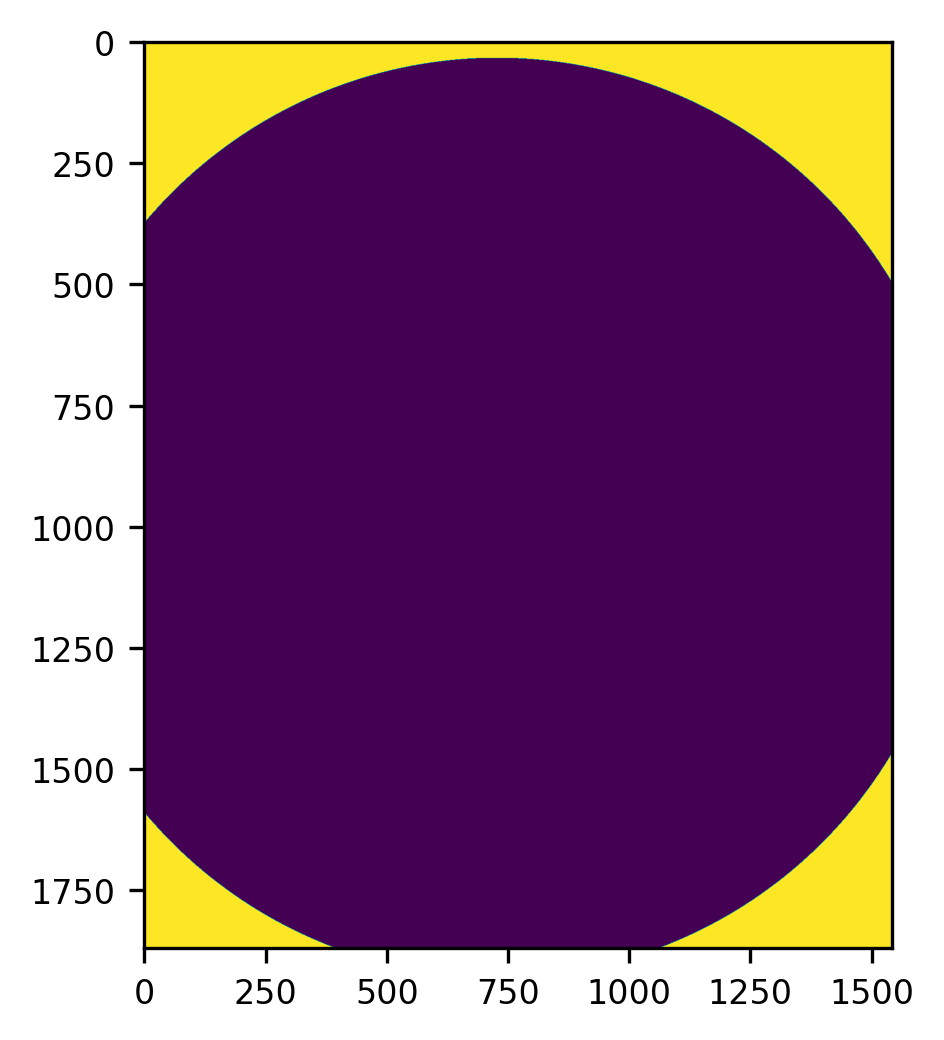

In [19]:
plt.imshow(BW_circle[20,:,:])

Image open to remove spurious stuff (only for 8bit)

In [15]:
# BW_circle = morphology.binary_opening(BW_circle, morphology.cube(4))

In [13]:
# plt.imshow(BW_circle[20,:,:])

Remove nuconnected stuff (only for 8bit)

In [17]:
# BW_circle[:,0,:] = 1
# BW_circle[:,-1,:] = 1
# BW_circle[:,:,0] = 1
# BW_circle[:,:,-1] = 1

In [18]:
# BW_circle = remove_unconnected(BW_circle)

In [20]:
# plt.imshow(BW_circle[20,:,:])

Save mask as a stack of tiffs with `dxchange`

In [21]:
# dxchange.write_tiff_stack(BW_circle, work_folder+"/masks/circle/slice.tiff", dtype='uint8')

### Pit mask
First we segment voxels within the pit region based on their GV

In [20]:
# BW_pit = (data_3D>0.000264) & (data_3D<0.00159) # 32bit float data
BW_pit = (data_3D>102) & (data_3D<127) # 8bit data

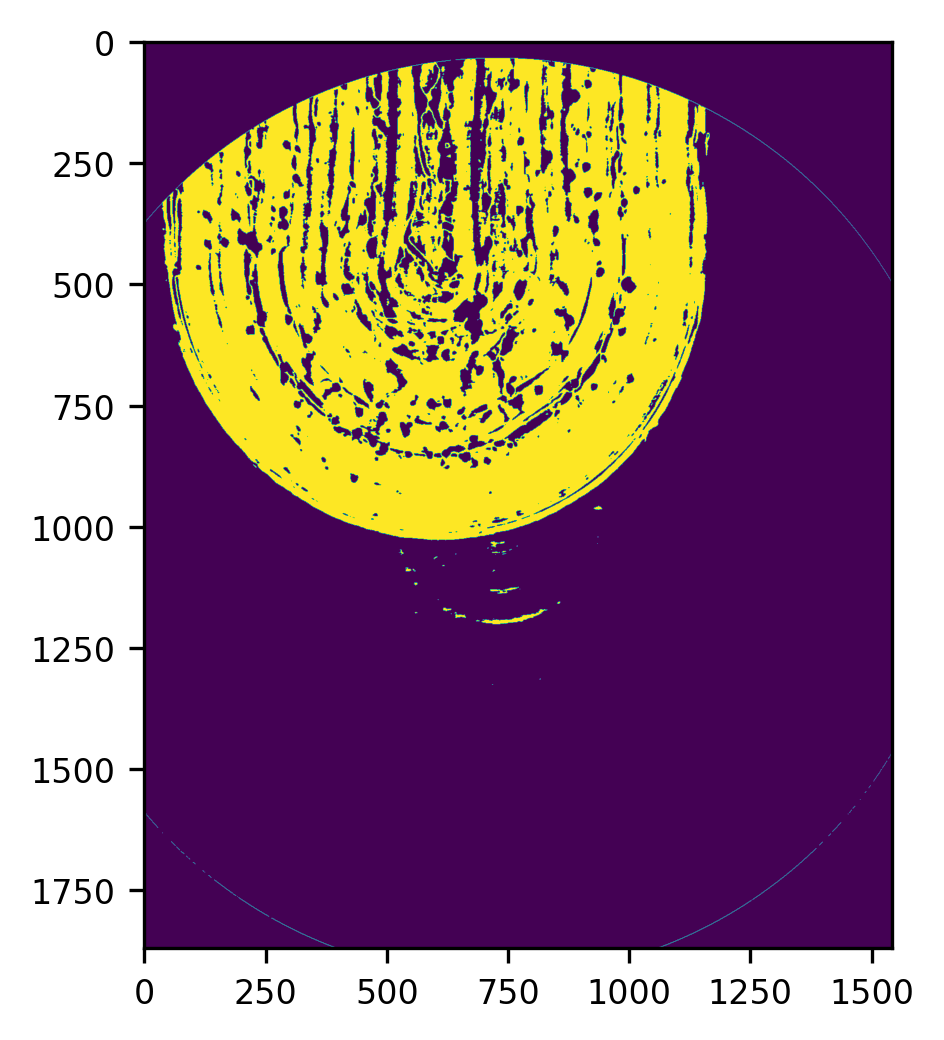

In [21]:
plt.imshow(BW_pit[0,:,:])

Image open to remove circle (don't)

In [22]:
# BW_pit = morphology.binary_opening(BW_pit, morphology.cube(2))

Fill holes within pit (don't)

In [23]:
# BW_pit = ndimage.binary_fill_holes(BW_pit)

Remove unconnected struts

In [24]:
BW_pit = remove_unconnected(BW_pit)

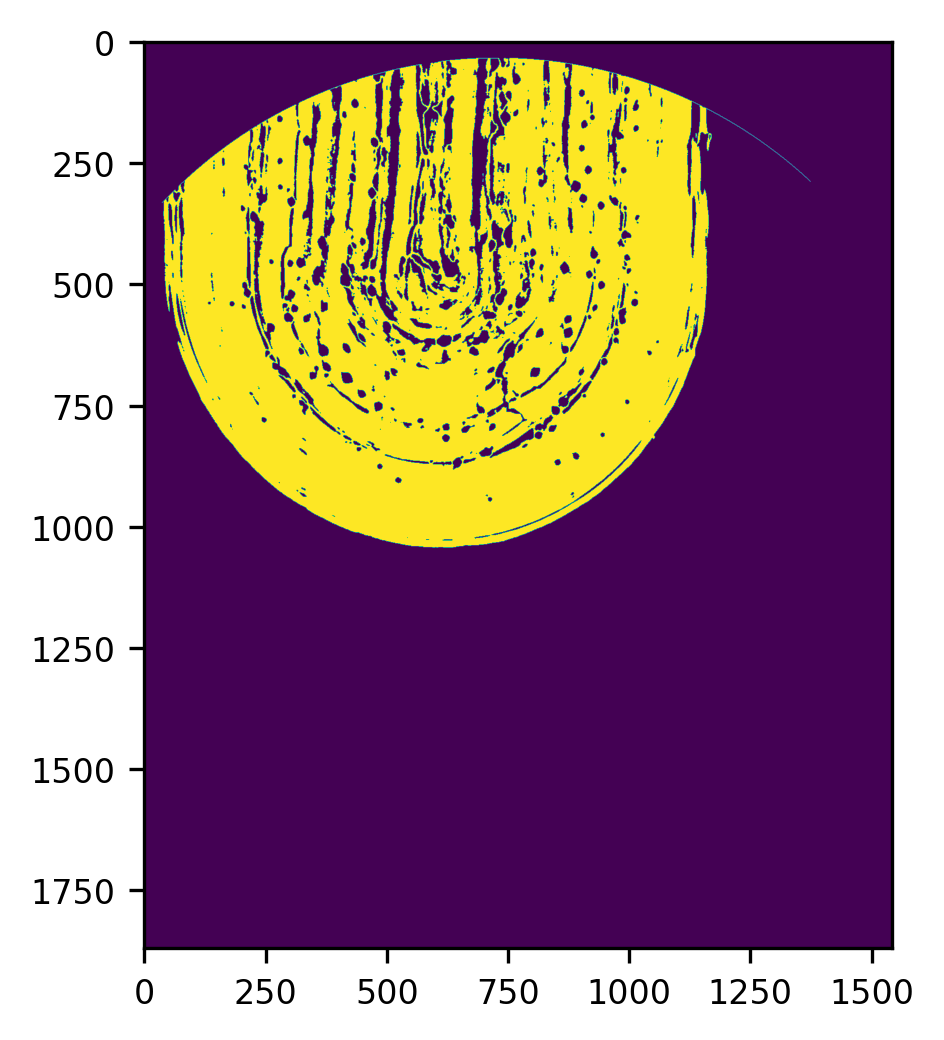

In [25]:
plt.imshow(BW_pit[50,:,:])

Close open surface of the pit with the cirle mask (don't)

In [26]:
# BW_pit2 = BW_pit & morphology.binary_dilation(BW_circle, morphology.cube(5))

In [27]:
# BW_pit2 = ndimage.binary_closing(~(BW_pit | BW_circle), morphology.cube(3), iterations=3 border_value=1)

Find holes within pit

In [28]:
BW_holes_within_pit = remove_largest(~(BW_pit | BW_circle))

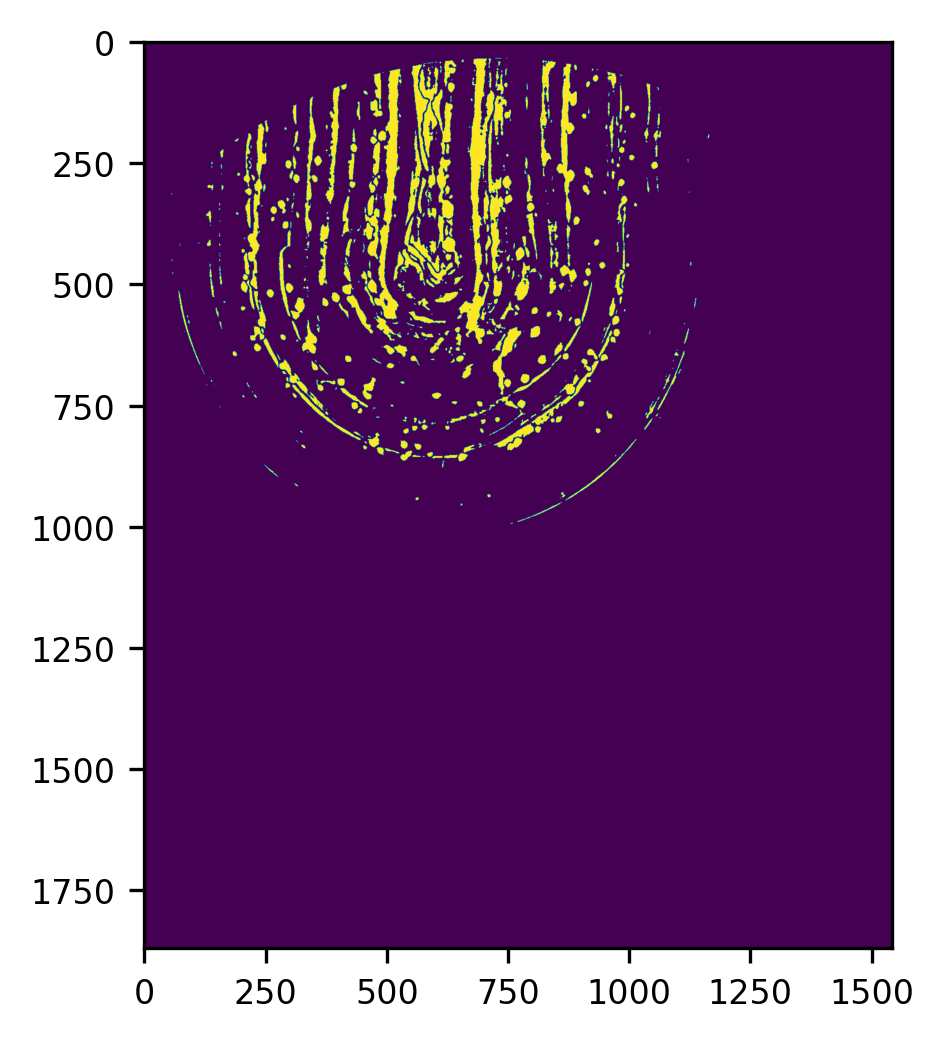

In [29]:
plt.imshow(BW_holes_within_pit[10,:,:])

Pit mask (holes removed)

In [30]:
BW_pit = BW_pit | BW_holes_within_pit

Image closing (optional)

In [31]:
BW_pit = ndimage.binary_closing(BW_pit, morphology.ball(1), iterations=5, border_value=1)

Followed by holes removal

In [32]:
BW_pit = ~remove_unconnected(~BW_pit)

Clear borders of the image

In [33]:
BW_pit[:,:,0:5] = False
BW_pit[:,:,-5:-1] = False
BW_pit[:,0:5,:] = False
BW_pit[:,-5:-1,:] = False

Image opening step

In [34]:
BW_pit = ndimage.binary_opening(BW_pit, morphology.ball(1))

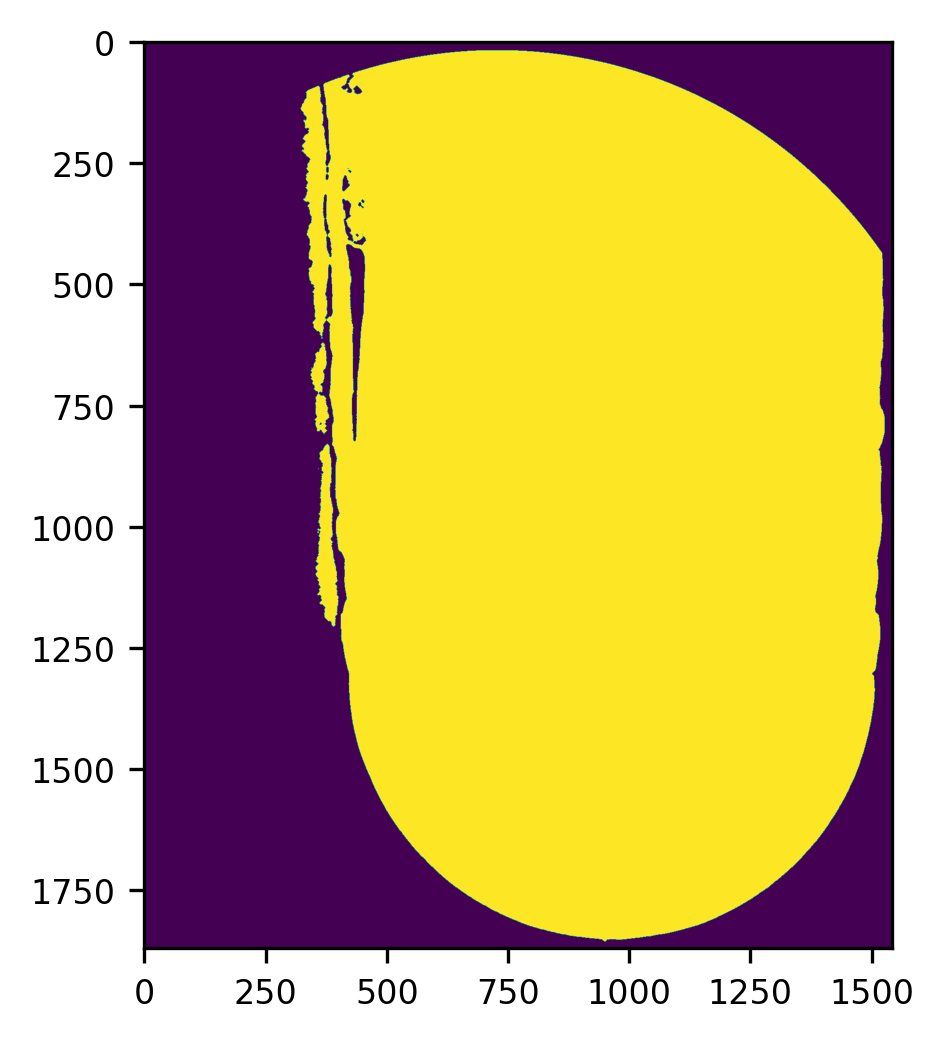

In [35]:
plt.imshow(BW_pit[-1,:,:])

Save mask as a stack of tiffs with `dxchange`

In [36]:
# dxchange.write_tiff_stack(BW_pit, work_folder+"/masks/pit_crop/slice.tiff")

### Manual correct and reload pit mask
This step is performed in ORS Dragonfly. After manual correction we can reload the modified mask:

In [6]:
input_file = work_folder+'/masks/pit_crop_modified/slice_0001.tif'

In [7]:
BW_pit = read_tiff_stack(input_file)

### Downsample the pit mask
For better efficiency we will compute the pit front mask on a downsampled version of the pit

In [75]:
downsample_factor = 2
BW_pit_small = ndimage.zoom(BW_pit, 1/downsample_factor, order=2, mode='reflect')

Binarize the downsampled mask

In [94]:
# BW_pit = BW_pit == 255 # full resolution version
BW_pit_small = BW_pit_small > 128

In [76]:
BW_pit_small.shape

(2323, 934, 772)

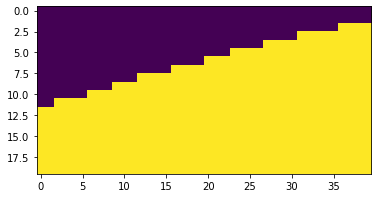

In [96]:
# plt.imshow(ndimage.zoom(BW_pit[-1,50:170,300:420], 0.5) > 128)
plt.imshow(BW_pit_small[2320,20:40,220:260])
# plt.imshow(BW_pit[-1,0:200,400:600])

### Pit boundary mask

In [97]:
BW_pit_boundary = BW_pit_small & ~ndimage.binary_erosion(BW_pit_small, morphology.ball(1), border_value=1)

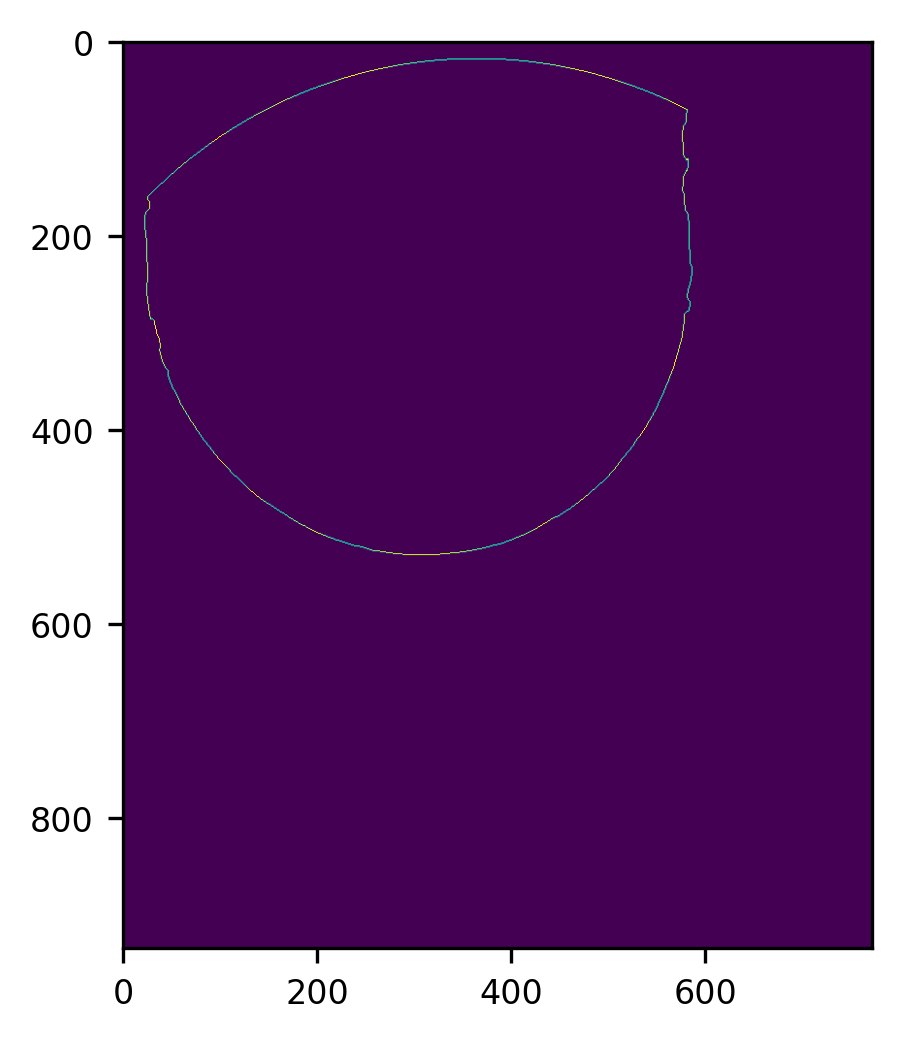

In [101]:
plt.imshow(BW_pit_boundary[50,:,:])

### Pit bottom mask: remove the portion of the pit exposed to air

In [116]:
# reload and downsample the circle mask
BW_circle = ndimage.zoom(read_tiff_stack(work_folder+"/masks/circle/slice.tiff"), 1/downsample_factor, order=2, mode='reflect')

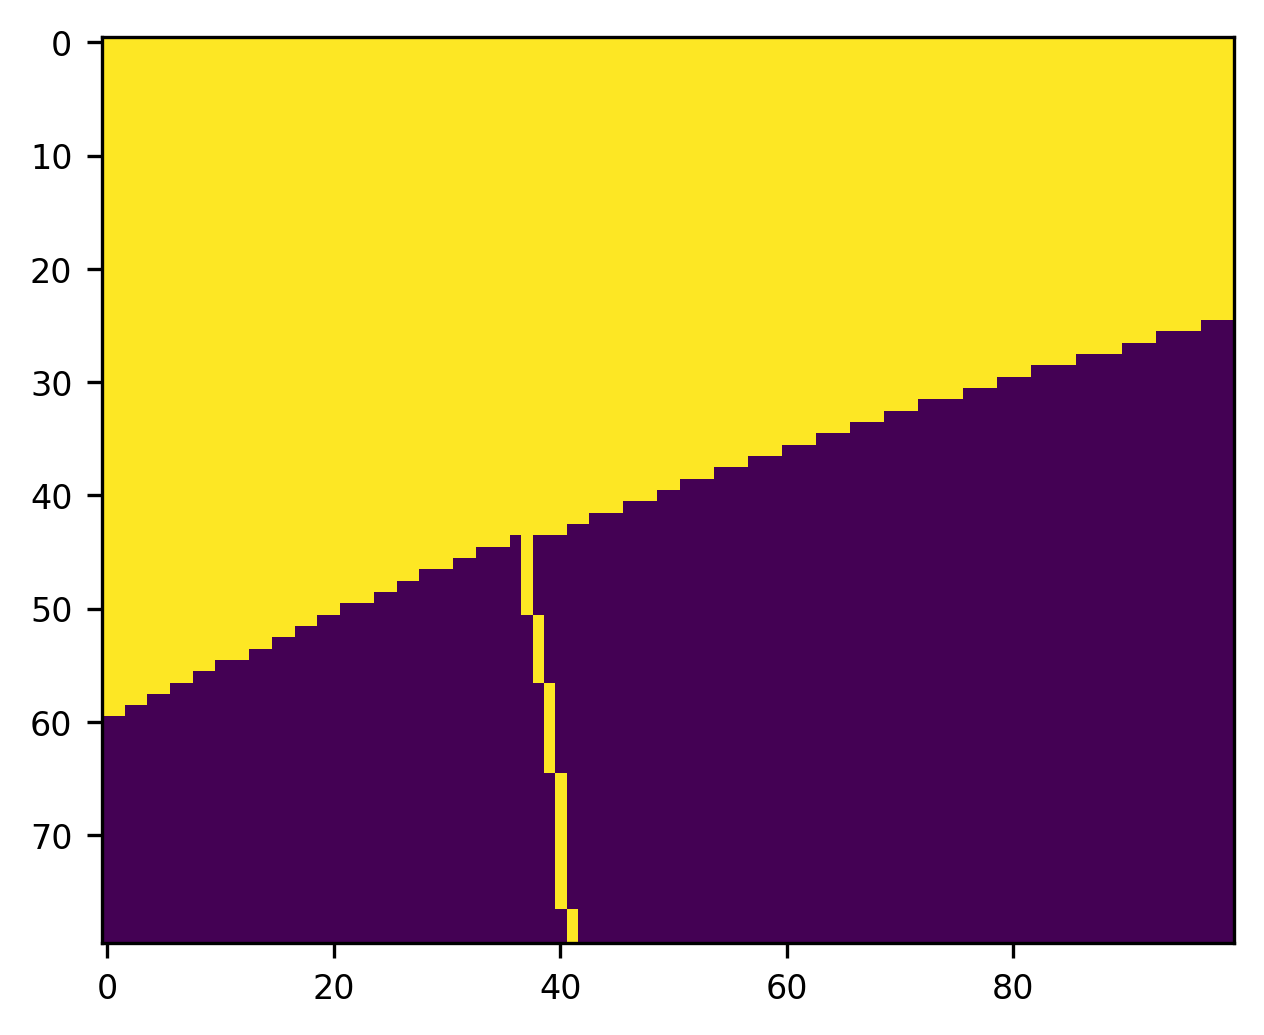

In [129]:
plt.imshow(BW_circle[-1,0:80,150:250]+BW_pit_boundary[-1,0:80,150:250])

Remove the top of the pit by eroding the circle mask

In [212]:
BW_pit_front = BW_pit_boundary & ndimage.binary_erosion(~BW_circle.astype('bool'), morphology.ball(2), border_value=True)

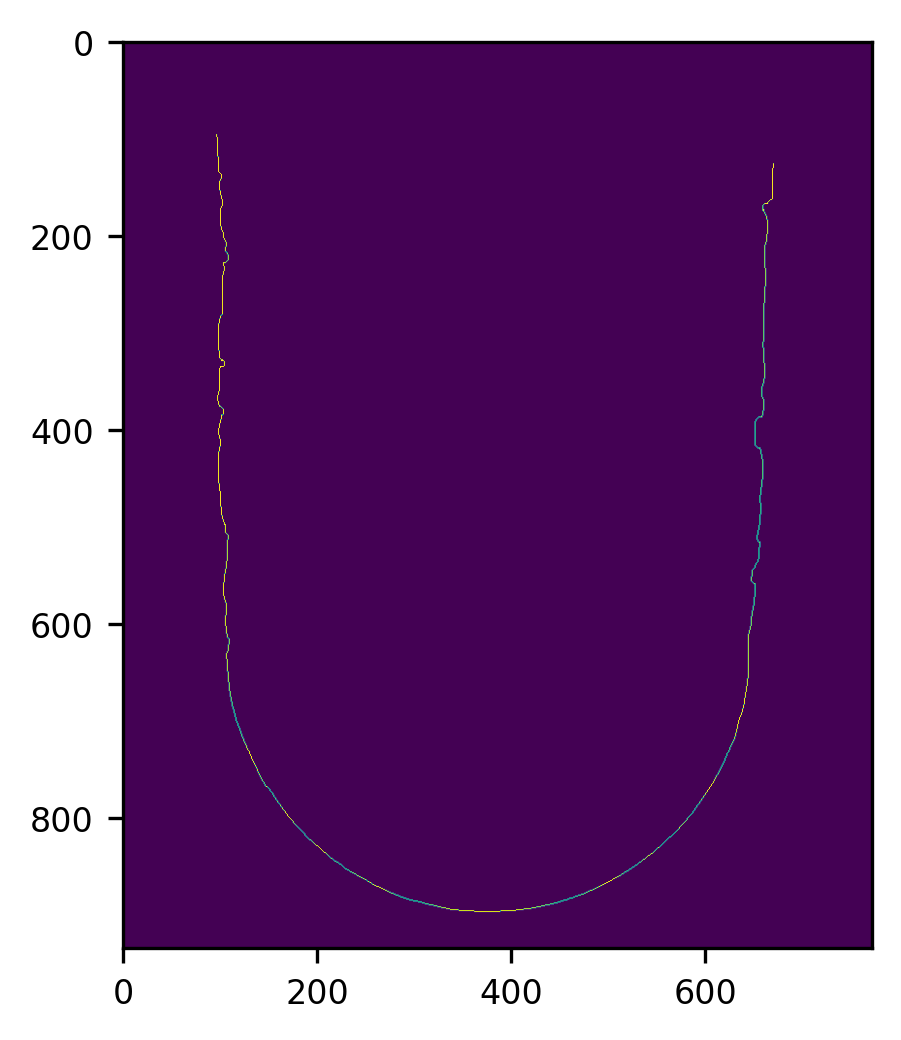

In [216]:
plt.imshow(BW_pit_front[1000,:,:]) 

Save mask as a stack of tiffs with `dxchange`

In [217]:
dxchange.write_tiff_stack(BW_pit_front, work_folder+"/masks/pit_crop_front_res2/slice.tiff")

## Mask of crystals inclusions within the pit
Select highly mineralized regions from their GV (brightest histogram tail..)

In [40]:
BW_pearls = data_3D>0.0022 # 32bit float data
# BW_pearls = data_3D>139 # 8bit int data

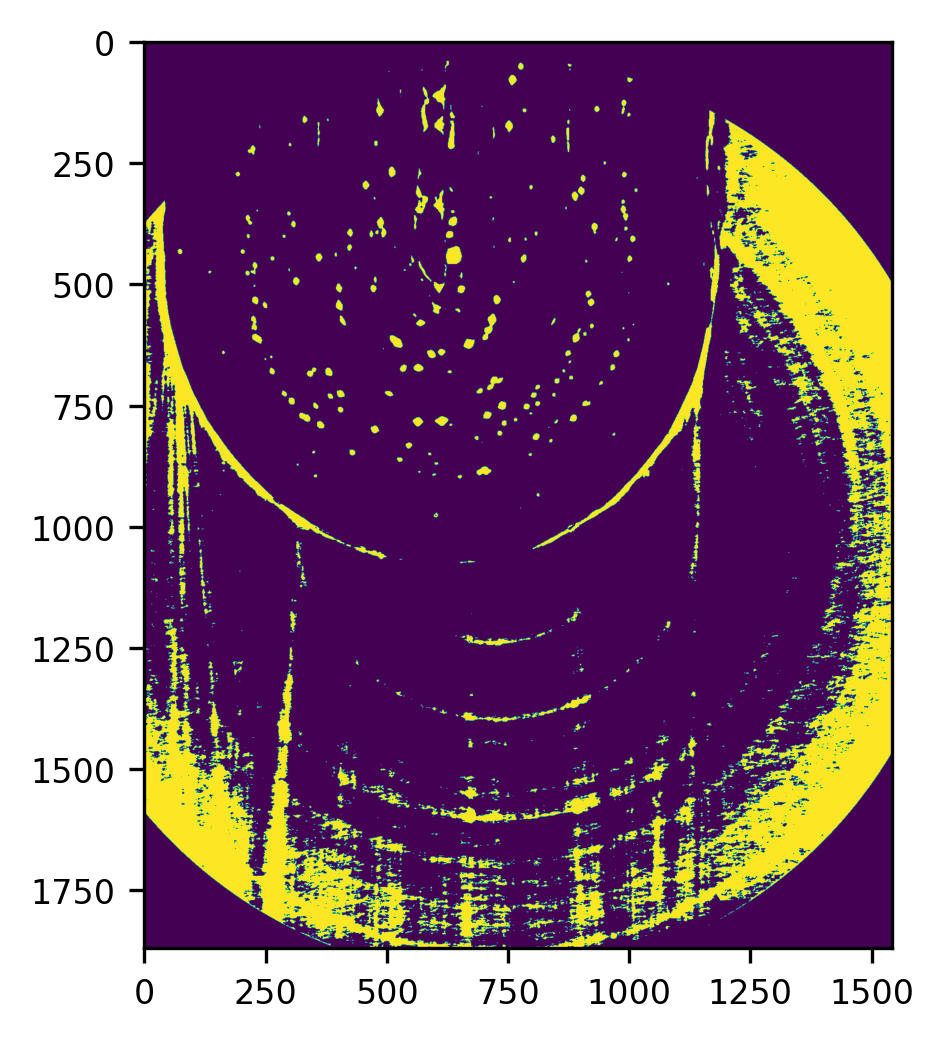

In [41]:
plt.imshow(BW_pearls[120,:,:])

### Load modified ROI of valid crystals
We have created a modified pit mask excluding the following areas containing mineral conglomerates and soil:
- fragmented layer on the upper-left side of the image
- pit core (probably exposed to air

In [42]:
input_file = work_folder+'/masks/pit_crop_valid_crystals/slice_0001.tif'

In [43]:
BW_valid_crystals = read_tiff_stack(input_file)

In [44]:
BW_valid_crystals = BW_valid_crystals == 255

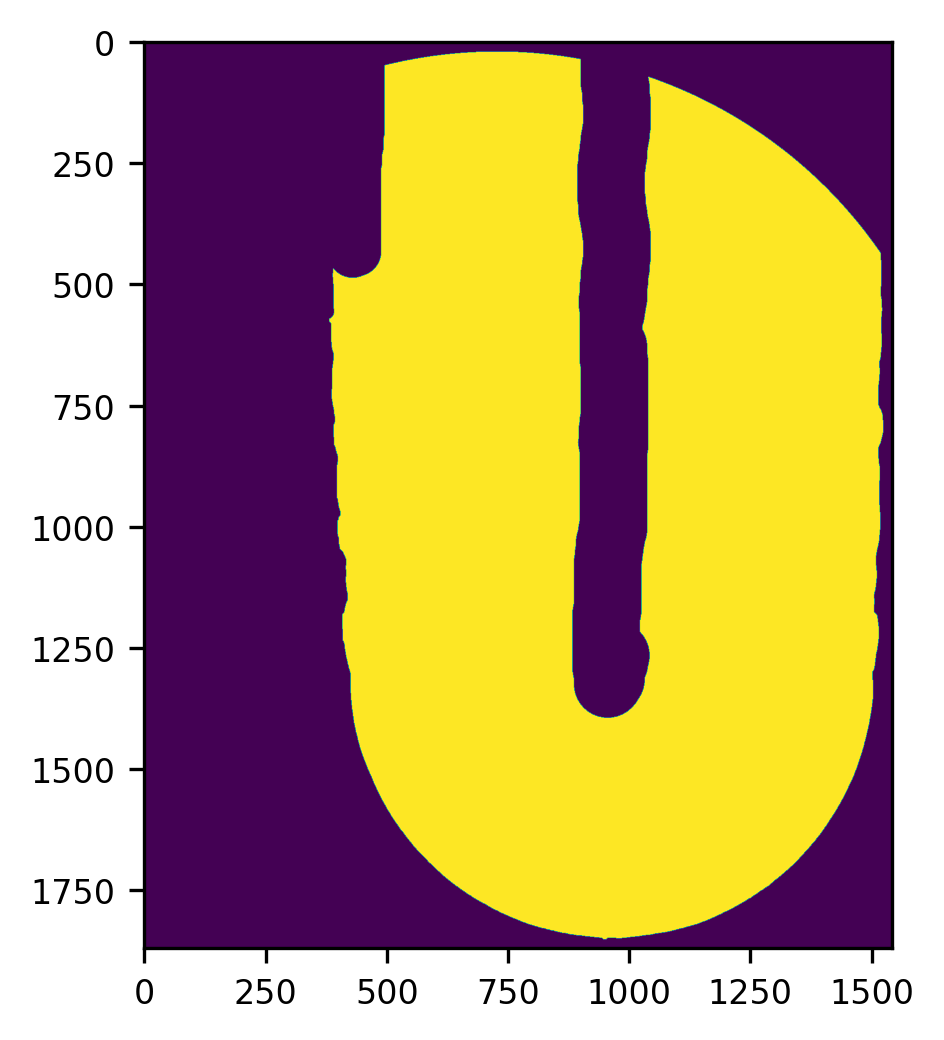

In [45]:
plt.imshow(BW_valid_crystals[-1,:,:])

Remove everything outside of the pit by applying eroded pit mask

In [46]:
BW_pearls = BW_pearls & ndimage.binary_erosion(BW_valid_crystals, morphology.ball(1), iterations=10, border_value=1)

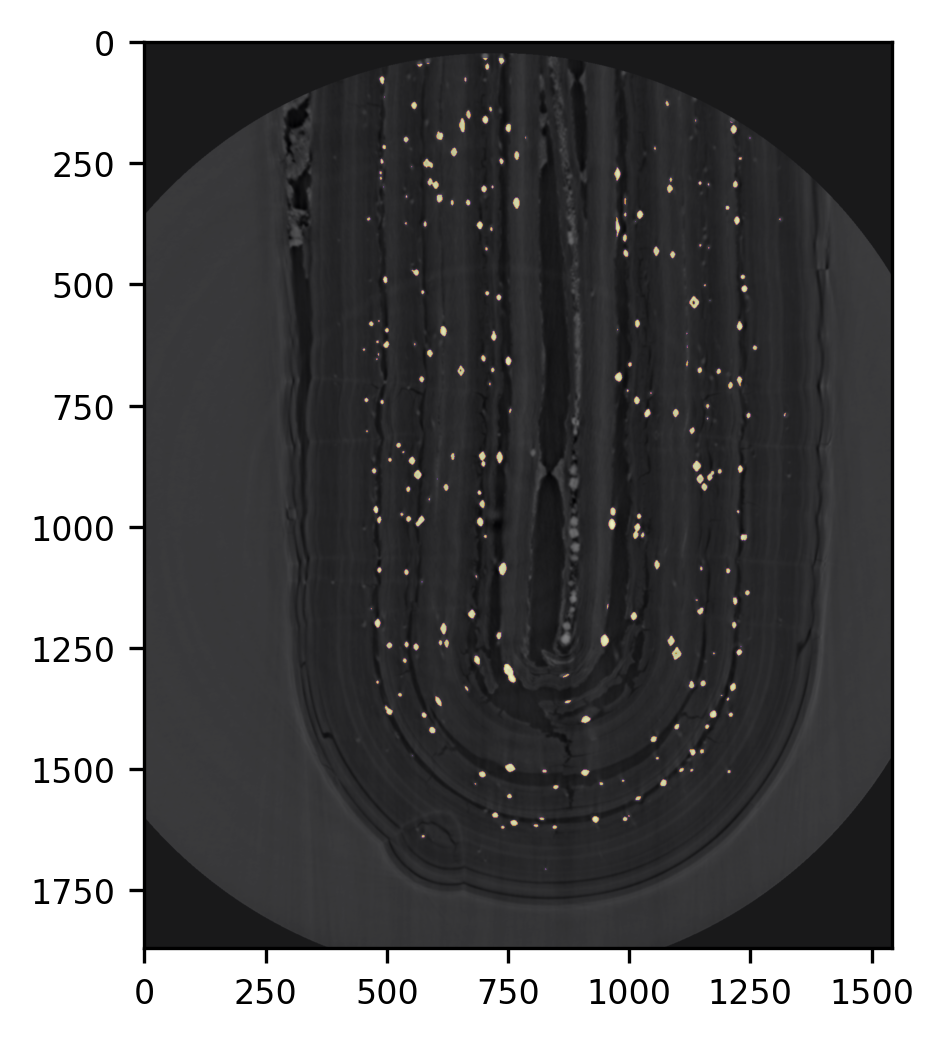

In [47]:
plt.imshow(data_3D[3150,:,:], cmap='gray')
plt.imshow(BW_pearls[3150,:,:], cmap='inferno', alpha=0.5)

Save mask of crystal inclusions - Save stack of tiffs with `dxchange`

In [51]:
dxchange.write_tiff_stack(BW_pearls, work_folder+"/masks/crystals_crop_valid/slice.tiff", dtype='uint8')

## Masks statistic
Get volume of different masked areas

In [11]:
pit_input_file = work_folder+'/masks/pit_crop/slice_0000.tif'
pit_valid_input_file = work_folder+'/masks/pit_crop_valid_crystals/slice_0001.tif'
crystals_input_file = work_folder+'/masks/crystals_crop_valid/slice_0001.tif'
voids_input_file = work_folder+'/masks/voids_crop/slice_0000.tif'

In [12]:
BW_pit = read_tiff_stack(pit_input_file)
BW_pit_valid = read_tiff_stack(pit_valid_input_file)
BW_crystals = read_tiff_stack(crystals_input_file)
BW_voids = read_tiff_stack(voids_input_file)

In [49]:
pit_vol = BW_pit.sum() # [voxels]

In [50]:
print('Pit mask size: ', BW_pit.shape[0]*1e-3, 'mm X', BW_pit.shape[1]*1e-3, 'mm X', BW_pit.shape[2]*1e-3, 'mm')
print('Pit volume: {:.2f} mm^3'.format(pit_vol*1e-9))

Pit mask size:  4.646 mm X 1.869 mm X 1.543 mm
Pit volume: 7.01 mm^3


In [53]:
pit_valid_vol = (BW_pit_valid >= 0.5).sum()

In [55]:
print('Analysed pit volume: {:.2f} mm^3'.format(pit_valid_vol*1e-9))

Analysed pit volume: 6.16 mm^3


In [58]:
crystals_vol = (BW_crystals >= 0.5).sum()

In [62]:
print('Volume of secondary phases: {:.3f} mm^3'.format(crystals_vol*1e-9))
print('.. {:.2f} % of pit volume.'.format(crystals_vol/pit_valid_vol*1e2))

Volume of secondary phases: 0.109 mm^3
.. 1.77 % of pit volume.


In [60]:
voids_vol = (BW_voids >= 0.5).sum()

In [63]:
print('Voids volume: {:.2f} mm^3'.format(voids_vol*1e-9))
print('.. {:.2f} % of pit volume.'.format(voids_vol/pit_vol*1e2))

Voids volume: 1.23 mm^3
.. 17.49 % of pit volume.


In [64]:
print('The remaining ', 100-1.77-17.49, '% is altered glass material')

The remaining  80.74000000000001 % is altered glass material


---
# Dependencies

In [7]:
import watermark

In [8]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2023-02-28T12:52:21.240920+03:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.4.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.18.0-425.3.1.el8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

dxchange  : 0.1.7
matplotlib: 3.6.0
watermark : 2.3.1
skimage   : 0.19.3
numpy     : 1.23.0
scipy     : 1.9.3
sys       : 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 15:55:03) 
[GCC 10.4.0]



---
# References
-  

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support